In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import tensorflow as tf
import utils

In [2]:
data_directory='/n/projects/smc/public/SMC/DLRegistration/BrainSlices/'

In [3]:
shp=[1,256,256,1]

In [4]:
raw=utils.get_raw_float_image(data_directory+'BrainSmaller.raw',shp)

In [5]:
def generate_batch(batch_size, rotation_range, shifting_range, raw_range):
    
    idices=np.random.choice(raw_range, size=batch_size)
    base=raw[idices,:,:]
    base=list(map(lambda x: sp.ndimage.rotate(x,np.random.uniform(-180, 180), reshape=False), base))
    base=np.stack(base)
    
    rotates=np.random.uniform(-rotation_range,rotation_range, size=batch_size)
    shifts=np.random.uniform(-shifting_range,shifting_range, size=[batch_size,2])
    truth=np.stack([rotates, shifts[:,0], shifts[:,1]], axis=1)
    
    dat=np.stack([sp.ndimage.rotate(sp.ndimage.shift(base[n], truth[n,1:3]), truth[n,0], reshape=False ) for n in range(0,batch_size)])
    altered=np.stack([base[n] for n in range(0,batch_size)])
    
    #truth[:,0]=truth[:,0]
    #truth[:,1:3]=truth[:,1:3]
    data=np.ndarray([batch_size,256,256,2])
    data[:,:,:,0]=base
    data[:,:,:,1]=dat
    
    data=data[:,64:192, 64:192,:]
    altered=np.reshape(altered[:,64:192, 64:192], [altered.shape[0],128,128,1])
    return (data, altered, truth)

In [6]:
remake=False

training_data=0
training_truth=0
if remake:
    training_data, training_altered, training_truth=generate_batch(100000,rotation_range=90,shifting_range=0.2, raw_range=range(100,raw.shape[0]-20))
    np.save(data_directory+'training_data', training_data)
    np.save(data_directory+'training_altered', training_altered)
    np.save(data_directory+'training_truth', training_truth)
else:
    training_data=np.load(data_directory+'training_data50.npy')
    training_altered=np.load(data_directory+'training_altered50.npy')
    training_truth=np.load(data_directory+'training_truth50.npy')

mean=np.mean(training_data)
std=np.std(training_data)

training_data=(training_data-mean)/std+0.5
training_altered=(training_altered-mean)/std+0.5

In [11]:
validation_data,validation_altered, validation_truth=generate_batch(100,rotation_range=50,shifting_range=0.2, raw_range=range(0,100))
validation_data=(validation_data-mean)/std+0.5
validation_altered=(validation_altered-mean)/std+0.5

In [34]:
tf.reset_default_graph()
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 128,128,2])
y=tf.placeholder(dtype=tf.float32, shape=[None,128,128,1])
z=tf.placeholder(dtype=tf.float32, shape=[None, 3])

lr=tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate')

xr=x
yr=y
zr=z

base_scaler=32

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

#Going down
A1=utils.leaky_relu(tf.layers.conv2d(xr, base_scaler, [5,5], padding='SAME', kernel_regularizer=regularizer))
A2=utils.leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
B2=utils.leaky_relu(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
C2=utils.leaky_relu(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
D2=utils.leaky_relu(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=utils.leaky_relu(tf.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
E2=utils.leaky_relu(tf.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

Flat=tf.reshape(E2, [-1, 8*8*16*base_scaler])
Dense=tf.layers.dense(Flat, 1024)
FlatDense=tf.layers.dense(Dense, 8*8*16*base_scaler)


P1=tf.layers.dense(FlatDense, 128)
parameters=tf.layers.dense(P1,3)


par_diff=tf.subtract(parameters, zr)
par_LSQ=tf.multiply(par_diff, par_diff)
#Added this to make the outlines more potent in error function
#OutError, MaskError=tf.split(LSQ, [1,1], 3)
#loss=1*tf.reduce_mean(OutError)+0.1*tf.reduce_mean(MaskError)
loss=10*tf.reduce_mean(par_LSQ)
l2_loss = tf.losses.get_regularization_loss()
loss=loss+0*l2_loss

train_op=tf.train.AdamOptimizer(learning_rate=lr, name='trainer').minimize(loss)

In [35]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=50)
for f in range(0,20000):
    idx=np.random.choice(training_data.shape[0], replace=False, size=[40])
    cur_train=training_data[idx,:,:,:]
    cur_altered=training_altered[idx,:,:,:]
    cur_truth=training_truth[idx,:]
    
    _, losses=sess.run([train_op, loss], feed_dict={x:cur_train, y:cur_altered, z:cur_truth, lr:0.0001})
    if (f%100==0):
        pars, valid_loss=sess.run([parameters,loss], feed_dict={x:validation_data, y:validation_altered, z:validation_truth})
        print([f,losses, valid_loss])
        #utils.plot_4x1(validation_data[0,:,:,0], validation_data[0,:,:,1], validation_altered[0,:,:,0], res[0,:,:,0])
        #print(cur_truth[0,:])
        #print(pars[0,:])
        #plt.show()
        saver.save(sess, data_directory+'NewModels/Model'+str(f))

[0, 2985.6152, 2993.4421]
[100, 282.32364, 576.3822]
[200, 159.3303, 354.9402]
[300, 77.72111, 199.81076]
[400, 143.33861, 248.81662]
[500, 44.309784, 227.0736]
[600, 130.75696, 234.34113]
[700, 63.852524, 182.95546]
[800, 81.624695, 205.91626]
[900, 24.67159, 133.92873]
[1000, 34.684883, 216.76648]
[1100, 32.678345, 242.19705]
[1200, 40.503227, 248.53757]
[1300, 20.351534, 205.11707]
[1400, 22.23346, 330.62402]
[1500, 9.855848, 188.45583]
[1600, 39.51299, 222.50963]
[1700, 23.322083, 163.97536]
[1800, 31.32306, 280.95468]
[1900, 23.689966, 256.602]


KeyboardInterrupt: 

# Load best model, perform inference

In [36]:
saver = tf.train.Saver()
sess=tf.Session()
sess.run(tf.global_variables_initializer())

data_model=data_directory+'NewModels/Model1900'
saver.restore(sess,data_model)

In [147]:
validation_data,validation_altered, validation_truth=generate_batch(1000,rotation_range=50,shifting_range=0.2, raw_range=range(0,80))
validation_data=(validation_data-mean)/std+0.5
validation_altered=(validation_altered-mean)/std+0.5

In [148]:
pars, valid_loss=sess.run([parameters, loss], feed_dict={x:validation_data, y:validation_altered, z:validation_truth})

87
[40.11295113  0.19708788 -0.02515743]
[36.17453     0.03477623  0.00101031]


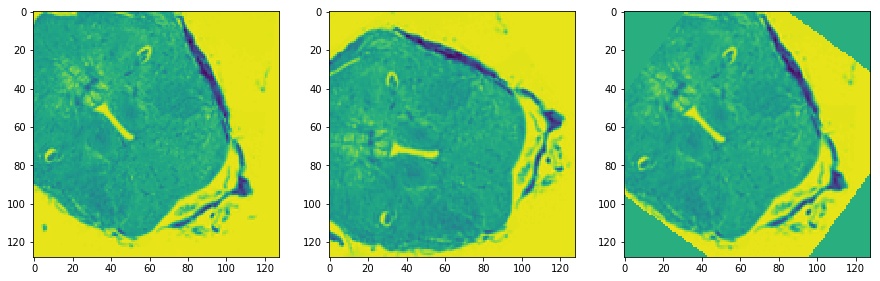

In [139]:
np.set_printoptions(suppress=True)
idx=np.random.randint(0,100)
print(idx)
utils.plot_3x1(validation_data[idx,:,:,0], validation_data[idx,:,:,1], sp.ndimage.rotate(validation_data[idx,:,:,1], -pars[idx,0], reshape=False))
print(validation_truth[idx])
print(pars[idx])

In [68]:
np.mean((pars[:,0]-validation_truth[:,0])*(pars[:,0]-validation_truth[:,0]))**0.5

8.899950310243703

In [143]:
np.arange(-5,5,.1)

array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. ,
       -3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9,
       -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8,
       -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7,
       -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0. ,  0.1,  0.2,  0.3,  0.4,
        0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
        1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,
        2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,
        3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,
        4.9])

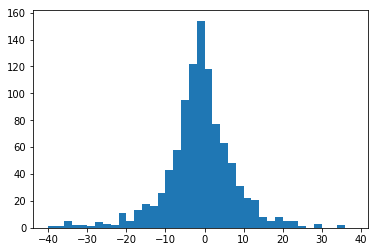

In [152]:
plt.hist((pars[:,0]-validation_truth[:,0]), bins=np.arange(-40,40,2))
plt.savefig('/n/projects/smc/Talks/20190312_BioKCConference/AngleError.jpg')

In [29]:
valid_loss

103.442444

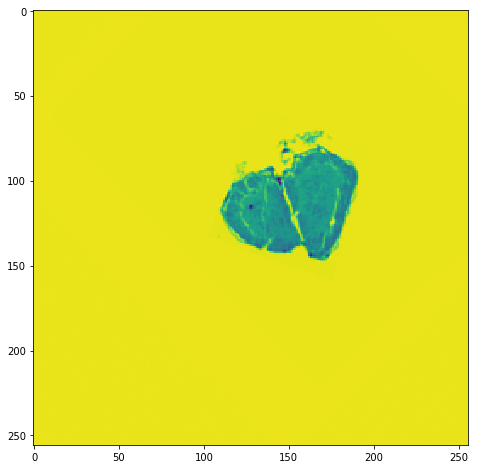

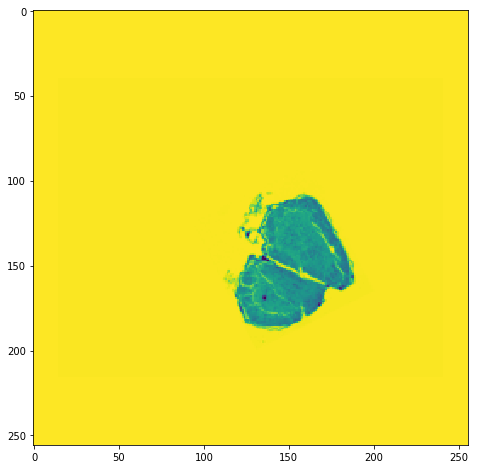

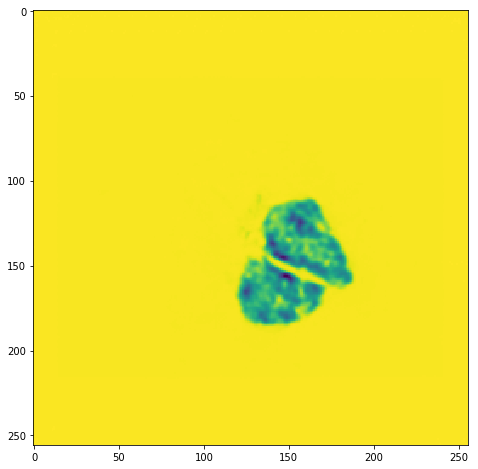

In [20]:
idx=np.random.randint(0,100)
plt.figure(figsize=[8,8])
plt.imshow(validation_data[idx,:,:,1])
plt.figure(figsize=[8,8])
plt.imshow(validation_truth[idx,:,:,0])
plt.figure(figsize=[8,8])
plt.imshow(res[idx,:,:,0])

In [52]:
idx=np.random.randint(0,100)
print(idx)
print(res[idx,:])
print(validation_truth[idx,:])

26
[-104.790146   42.04472    42.314995]
[-127.96739047   46.01618485   48.00432569]
